In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

matrix= scipy.io.loadmat("/home/ponnana/PhD/Yinling_copy/data_new.mat")


m = matrix["data_new"][:,0]
v =  matrix["data_new"][:,1]
s = matrix["data_new"][:,2]
k = matrix["data_new"][:,3]

tExp = [0.01058, 0.03158, 0.05258, 0.07358, 0.09458, 0.1156, 0.1366, 0.1576, 0.1786, 0.1996, 0.2206,
          0.2300, 0.2756, 0.3316, 0.3876, 0.4436, 0.4496, 0.5556, 0.6116, 0.6676, 0.7206, 0.7796, 0.8356,
          0.8916, 0.9476, 1.004, 1.060, 1.105, 1.124, 1.153, 1.182, 1.211, 1.240, 1.269, 1.298, 1.327,
          1.356, 1.385, 1.414, 1.443, 1.472, 1.501, 1.530, 1.559, 1.588, 1.617, 1.646, 1.670]

tExp = np.array(tExp)


t1,t2 = 0.24,1.1
xExp = np.concatenate((matrix["data_new"], tExp.reshape(-1,1)), axis=1)
# xExp = xExp.astype(double)


maxValues = np.max(xExp,axis=0)
maxValues[-1]=1
xExpNormal = xExp/maxValues
truncIndex = np.where(xExpNormal[:,1]>=0.0999)
xExpTruncNormal = xExpNormal[truncIndex,:]
xExpTruncNormal = np.squeeze(xExpTruncNormal)
tExpTrunc = xExpTruncNormal[:,-1]


import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1000)
np.random.seed(1000)

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=15)
parser.add_argument('--batch_size', type=int, default=100)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')

# Parse arguments when running in Jupyter notebook
args = parser.parse_args(args=[])

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

class ODEFuncMean(nn.Module):

    def __init__(self):
        super(ODEFuncMean, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        ).to(torch.float64)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcMean = ODEFuncMean().to(device)

import numpy as np
import torch
import torchvision
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from torch import nn, optim
import matplotlib.pyplot as plt

# # ################## Part 1: load data and create batch ##################
# # Generate data and shuffle
# N_total = 600
# N_train = 500
# x = torch.unsqueeze(torch.linspace(0, 1, N_total), dim=1)
# r = torch.randperm(N_total)
# x = x[r, :]
# y = 0.2 + 0.4 * torch.pow(x, 2) + 0.3 * x * torch.sin(15 * x) + 0.05 * torch.cos(50 * x)

In [3]:
# Generate data and shuffle
N_total = 43
N_train = 43
x = torch.unsqueeze(torch.tensor(xExpTruncNormal[:,-1]),dim= 1)
y = torch.unsqueeze(torch.tensor(xExpTruncNormal[:,3]),dim= 1)

# plt.scatter(x, y)
# plt.show()
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.y = y
        self.x = x

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        y1 = self.y[idx]
        x1 = self.x[idx]
        return (x1, y1)


trainset = CustomDataset(x[0:N_train, :], y[0:N_train, :])
#testset = CustomDataset(x[N_train:N_total, :], y[N_train:N_total, :])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=43)
#test_loader = torch.utils.data.DataLoader(testset, batch_size=43)

# ################## Part 2: Define Model and initialize ##################
# This part need to be changed to define a new model
# model = nn.Sequential(nn.Linear(1, 1024, bias=True),
#                       nn.ReLU(),
#                       # nn.Linear(128, 64, bias=True),
#                       # nn.ReLU(),
#                       nn.Linear(1024, 1, bias=True)
#                       )
model = nn.Sequential(
    nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
    ).to(torch.float64)

# ############## This part can be changed to different initialization
# Initialize as 0

# Initialize as uniform [-1, 1]
# for p in model.parameters():
#     p.data.uniform_(-1, 1)
def init_weights(m):
    if isinstance(m, nn.Linear):
        m.weight.data.uniform_(-1, 1)
        m.bias.data.uniform_(-1, 1)

# Initialize as normal
# m.bias.data.normal_(0, 1)
# m.weight.data.normal_(0, 0.03)

model.apply(init_weights)

# Initialize as normal
#
# ########################################################################

# ################## Part 3: Define Loss and optimizer ##################

# ######## This can be changed to different loss function, e.g., L2loss
# ######## and different optimization parameter，e.g. regularization, learning rata.
criterion = torch.nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# ########################################################################


# ################## Part 4: Optimization ##################
def train_NN():
    model.train()
    for images, labels in train_loader:
        images = images.view(images.shape[0], -1)
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss


def test_NN(loader):
    model.eval()
    loss = 0
    for images, labels in loader:
        images = images.view(images.shape[0], -1)
        out = model(images)
        loss += criterion(out, labels)
    loss = loss / len(loader)
    return loss



train_loss = np.array([])
# test_loss = np.zeros((N_epoch, 1))
loss1 = 10
count = 0
while loss1>=0.0001:
    loss1 = train_NN()
    # train_loss[epoch, 0] = test_NN(train_loader)
    dummy = test_NN(train_loader)
    train_loss= np.append(train_loss,dummy.item())
    # test_loss[epoch, 0] = test_NN(test_loader)
    print(
        f'Epoch: {count:03d}, train loss: {train_loss[count]:.7f}') #, test loss: {test_loss[epoch, 0]:.7f}')
    count = count+1

x_test = torch.unsqueeze(torch.linspace(0.1156, 1.670, 1999), dim=1).double()
y_test = model(x_test)

plt.plot(x[0:N_total], y[0:N_total], 'bo')
plt.plot(x_test, y_test.detach().numpy(), 'r')
plt.show()

Epoch: 000, train loss: 2.2694126
Epoch: 001, train loss: 1.8068673
Epoch: 002, train loss: 1.4185000
Epoch: 003, train loss: 1.0991154
Epoch: 004, train loss: 0.8408281
Epoch: 005, train loss: 0.6338911
Epoch: 006, train loss: 0.4683160
Epoch: 007, train loss: 0.3355821
Epoch: 008, train loss: 0.2296147
Epoch: 009, train loss: 0.1468192
Epoch: 010, train loss: 0.0854628
Epoch: 011, train loss: 0.0447505
Epoch: 012, train loss: 0.0238082
Epoch: 013, train loss: 0.0207312
Epoch: 014, train loss: 0.0319382
Epoch: 015, train loss: 0.0521878
Epoch: 016, train loss: 0.0755015
Epoch: 017, train loss: 0.0966842
Epoch: 018, train loss: 0.1125507
Epoch: 019, train loss: 0.1221636
Epoch: 020, train loss: 0.1261738
Epoch: 021, train loss: 0.1258494
Epoch: 022, train loss: 0.1223020
Epoch: 023, train loss: 0.1161442
Epoch: 024, train loss: 0.1075684
Epoch: 025, train loss: 0.0966771
Epoch: 026, train loss: 0.0838291
Epoch: 027, train loss: 0.0698083
Epoch: 028, train loss: 0.0557478
Epoch: 029, tr

KeyboardInterrupt: 

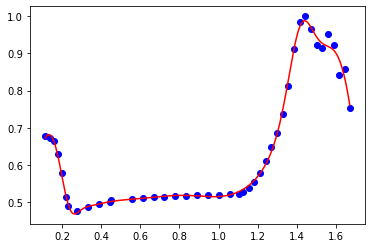

In [5]:
x_test = torch.unsqueeze(torch.linspace(0.1156, 1.670, 1999), dim=1).double()
y_test = model(x_test)

plt.plot(x[0:N_total], y[0:N_total], 'bo')
plt.plot(x_test, y_test.detach().numpy(), 'r')
plt.show()

In [8]:
torch.save(model.state_dict(), 'interpolKurt_64_64.pth')

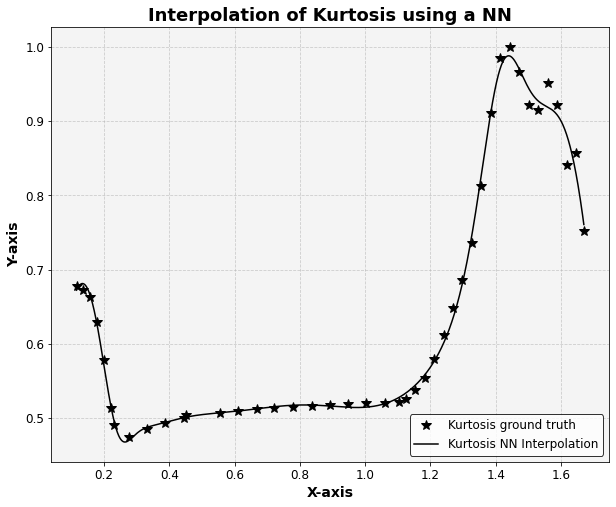

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(x[0:N_total], y[0:N_total], 'k*', label='Kurtosis ground truth',markersize= 10)
plt.plot(x_test, y_test.detach().numpy(), 'k-', label = 'Kurtosis NN Interpolation')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("Interpolation of Kurtosis using a NN", fontsize=18, fontweight='bold')
ax.set_xlabel("X-axis", fontsize=14, fontweight='bold')
ax.set_ylabel("Y-axis", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='lower right', fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')

plt.savefig('interpolKurtNN.pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [98]:
loss1

tensor(0.0002, dtype=torch.float64, grad_fn=<MseLossBackward0>)

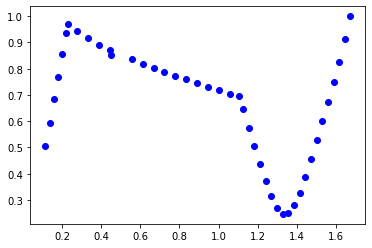

In [71]:
plt.plot(xExpTruncNormal[:,-1], xExpTruncNormal[:,0], 'bo')

In [56]:
x_test

tensor([[0.0000e+00],
        [5.0050e-04],
        [1.0010e-03],
        ...,
        [9.9900e-01],
        [9.9950e-01],
        [1.0000e+00]])

In [57]:
x_test = torch.unsqueeze(torch.linspace(0, 1.67, 1000), dim=1)
y_test = model(x_test)

plt.plot(x[0:N_total], y[0:N_total], 'bo')
plt.plot(x_test, y_test.detach().numpy(), 'r')
plt.show()

RuntimeError: mat1 and mat2 must have the same dtype, but got Float and Double